In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
import glob
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from StringIO import StringIO
MetalFlag=1
import scipy.ndimage as ndimage

In [3]:
path = "/data/OWN/paramstest/e01_t20/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,stars,gas")

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
myhalo.r_virial(600)

| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,19, 0|
|    | 0, 0, 1|


In [5]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)

In [6]:
def MagCalc(myage,myMagAge,myMag,SolMagBand,mymass,mymetal,myMagMet):

    #Select first 2 matrices by metal...
    #myMagAgeSelected=myMagAge[np.where(abs(mymetal-myMagMet)<=abs(mymetal-myMagMet).min())]
    myMagSelected=myMag[np.where(abs(mymetal-myMagMet)<=abs(mymetal-myMagMet).min())]
    #...then search for the closest star age in the selected list
    ind=np.argmin(abs(myage-myMagAgeSelected))
    #print ind
    #Calculate Magnitude
    mag=myMagSelected[0]-2.5*np.log10(mymass)
    #Calculate luminosity
    lum=10**(-(mag-SolMagBand)/2.5)  #in Solar Luminosities
    return mag,lum

In [29]:
MetalFlag=1
band = 'u'

In [30]:
MagMet=MagAge=MagU=MagB=MagV=MagR=MagI=MagJ=MagH=MagK=np.array([0])
if MetalFlag==0:
    with open('/home/arturo/GoodLuminosityFile/met0.02-age1.76-10.13.dat') as maginfo:
        for line in maginfo:
             #print(line)

             result=np.genfromtxt(StringIO(line),comments='#',delimiter=None)
             #magage=np.append(magage,result[0])
             #print result
             if len(result)>0:
                 MagMet=np.append(MagMet,result[0])
                 MagAge=np.append(MagAge,result[1])
                 MagU=np.append(MagU,result[3])
                 MagB=np.append(MagB,result[4])
                 MagV=np.append(MagV,result[5])
                 MagR=np.append(MagR,result[6])
                 MagI=np.append(MagI,result[7])
                 MagJ=np.append(MagJ,result[8])
                 MagH=np.append(MagH,result[9])
                 MagK=np.append(MagK,result[10])
else:
    with open('/home/arturo/GoodLuminosityFile/AllData.dat') as maginfo:
        for line in maginfo:
             #print(line)

             result=np.genfromtxt(StringIO(line),comments='#',delimiter=None)
             #magage=np.append(magage,result[0])
             #print result
             if len(result)>0:
                 MagMet=np.append(MagMet,result[0])
                 MagAge=np.append(MagAge,result[1])
                 MagU=np.append(MagU,result[3])
                 MagB=np.append(MagB,result[4])
                 MagV=np.append(MagV,result[5])
                 MagR=np.append(MagR,result[6])
                 MagI=np.append(MagI,result[7])
                 MagJ=np.append(MagJ,result[8])
                 MagH=np.append(MagH,result[9])
                 MagK=np.append(MagK,result[10])
    MagMet=MagMet[1:]
    MagAge=MagAge[1:]/10**6
    MagU=MagU[1:]
    MagB=MagB[1:]
    MagV=MagV[1:]
    MagR=MagR[1:]
    MagI=MagI[1:]
    MagJ=MagJ[1:]
    MagH=MagH[1:]
    MagK=MagK[1:]


In [53]:
print myhalo.st.mass.max()


2.86966e+06


In [10]:
def MagCalc_u(sim,i):#(myage,myMagAge,myMag,SolMagBand,mymass,mymetal,myMagMet):
    #metind=myMagMet[np.where(abs(mymetal-myMagMet)<=abs(mymetal-myMagMet).min())]
    #print 'mymetal',mymetal
    #print 'npwhere',np.where(abs(mymetal-myMagMet)<=abs(mymetal-myMagMet).min())
    #print 'metind',metind.shape
    #print 'myMagMetSelected',myMagMet[np.where(abs(mymetal-myMagMet)<=abs(mymetal-myMagMet).min())]

    #Select first 2 matrices by metal...
    MagAgeSelected=MagAge[np.where(abs(sim.st.metal[i]-MagMet)<=abs(sim.st.metal[i]-MagMet).min())]
    MagSelected=MagU[np.where(abs(sim.st.metal[i]-MagMet)<=abs(sim.st.metal[i]-MagMet).min())]
    #print 'myMagAgeSelected ',myMagAgeSelected,myMagAgeSelected.shape
    #print 'myMagSelected ',myMagSelected,myMagSelected.shape

    #...then search for the closest star age in the selected list
    ind=np.argmin(abs(sim.st.age[i]-MagAgeSelected))
    #print 'star age:',myage,'Magnit',myMagAgeSelected[ind]
    #print 'log10(mymass)',log10(mymass)
    #Calculate Magnitude
    mag=MagSelected[ind]-2.5*np.log10(sim.st.mass[i])
    #print 'myMagSelected[ind]',myMagSelected[ind],'calc mag:',mag
    #Calculate luminosity
    SolMagBand = 5.56
    lum=10**(-(mag-SolMagBand)/2.5)  #in Solar Luminosities
    return mag,lum


In [32]:
lentho=1e6
band= "u"
if band=="u":
        #print MagCalc(myhalo.st.age[0],MagAge,MagU,5.56,myhalo.st.mass[0],myhalo.st.metal[0],MagMet)
        #print MagCalc(myhalo.st.age[1],MagAge,MagU,5.56,myhalo.st.mass[1],myhalo.st.metal[1],MagMet)

        myMagnitude=np.array([ MagCalc_u(myhalo,x)  for x in np.arange(len(myhalo.st.age))]) # MagSol taken from webpage indicated above
        #print 'myMagnitude:',myMagnitude.shape,myMagnitude
        magst_U=myMagnitude[:,0]
        lumst_U=myMagnitude[:,1]



In [40]:
def face_on_st_lum(sim,lims,cond,points,thikness=.5):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[cond,0], 
                                       sim.st.pos3d[cond,1],
                                       bins=(edges, edges),
                                       weights=(lumst_B+lumst_U)[cond])
    result = H.T
    return result, edges

def edge_on_st_lum(sim,lims,cond,points,thikness=.5):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[cond,0], 
                                       sim.st.pos3d[cond,2],
                                       bins=(edges, edges),
                                       weights=(lumst_B+lumst_U)[cond])
    result = H.T
    return result, edges

In [51]:
print np.log10(np.abs(myhalo.st.age)*1e9).max()

10.131


<IPython.core.display.Javascript object>


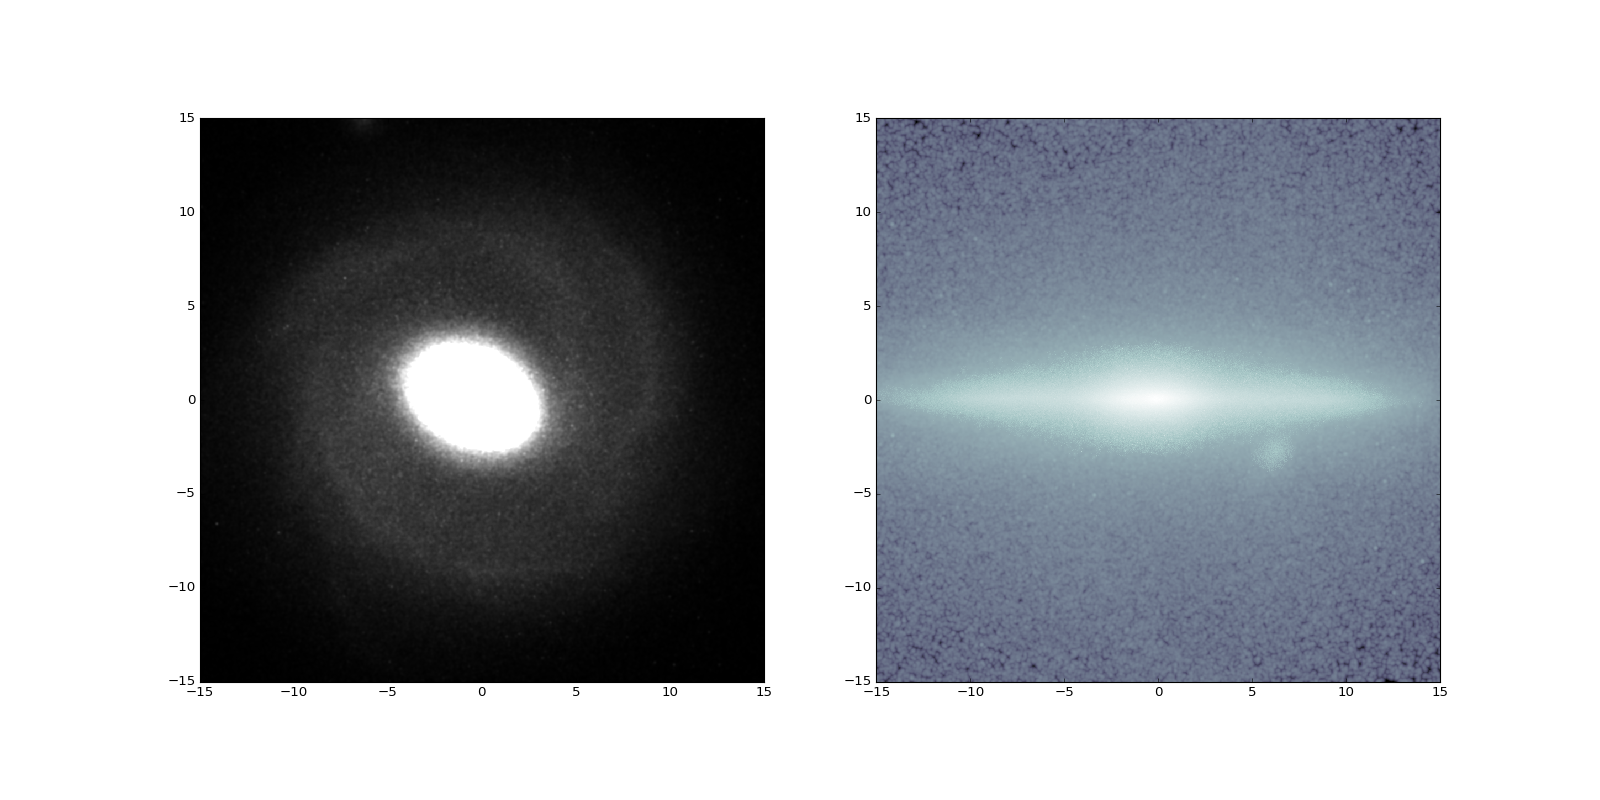

faceMin = 24.6397309763, faceMax = 828747959.308


In [41]:
fig, ax1 = plt.subplots(1,2,figsize=[20,10])
ax1[0].patch.set_facecolor("k")
ax1[1].patch.set_facecolor("k")
#ax1[0].set_xlim([-6.1,-4.9])
#ax1[0].set_ylim([-4.4,-3.1])
rho_prop , age_lim =0.008, -3
rhomax = rho_prop * np.mean(myhalo.st.rho)
condition = [True for i in myhalo.st.mass]#(myhalo.st.rho<rhomax)&(myhalo.st.age<age_lim)
sigma = 2

face_1, edges = face_on_st_lum(myhalo,[-15,15],condition,1024)
face_1 = ndimage.gaussian_filter(face_1, sigma=sigma, order=0)


edge_1, edges = edge_on_st_lum(myhalo,[-15,15],condition,1024)
edge_1 = ndimage.gaussian_filter(edge_1, sigma=sigma, order=0)

#######################################################################################################################3

condition = (myhalo.st.rho>rhomax)&(myhalo.st.age<age_lim)

face_2, edges = face_on_st_lum(myhalo,[-15,15],condition,1024)
#face_2 = ndimage.gaussian_filter(face_2, sigma=0.01, order=0)


edge_2, edges = edge_on_st_lum(myhalo,[-15,15],condition,1024)
#edge_2 = ndimage.gaussian_filter(edge_2, sigma=0.01, order=0)


face = face_1
edge = 2*edge_2 + edge_1 
print "faceMin = {0}, faceMax = {1}".format(face.min(),face.max())

mass_1 = ax1[0].imshow(face, interpolation='nearest', origin='low',cmap="gist_gray",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],vmax=3e7
                  )


mass_1 = ax1[1].imshow(edge, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e1)
                  )



In [148]:
Z2 = ndimage.gaussian_filter(face, sigma=2.0, order=0)

<IPython.core.display.Javascript object>


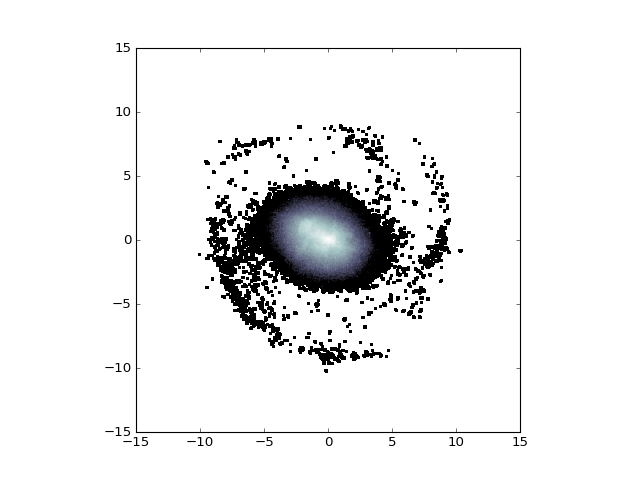

In [149]:
fig, ax = plt.subplots()
mass_1 = ax.imshow(Z2, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=2e6)
                  )

In [35]:
band = "b"
if band=="b":
        #print MagCalc(age[0],MagAge,MagB,5.45,mass[0],metal[0],MagMet)
        #print MagCalc(age[1],MagAge,MagB,5.45,mass[1],metal[1],MagMet)

        myMagnitude=np.array([ MagCalc(myhalo.st.age[x],MagAge,MagB,5.45,myhalo.st.mass[x],myhalo.st.metal[x],MagMet)  for x in np.arange(len(myhalo.st.age))]) # MagSol taken from webpage indicated above
        #print 'myMagnitude:',myMagnitude.shape,myMagnitude
        magst_B=myMagnitude[:,0]
        lumst_B=myMagnitude[:,1]


<IPython.core.display.Javascript object>


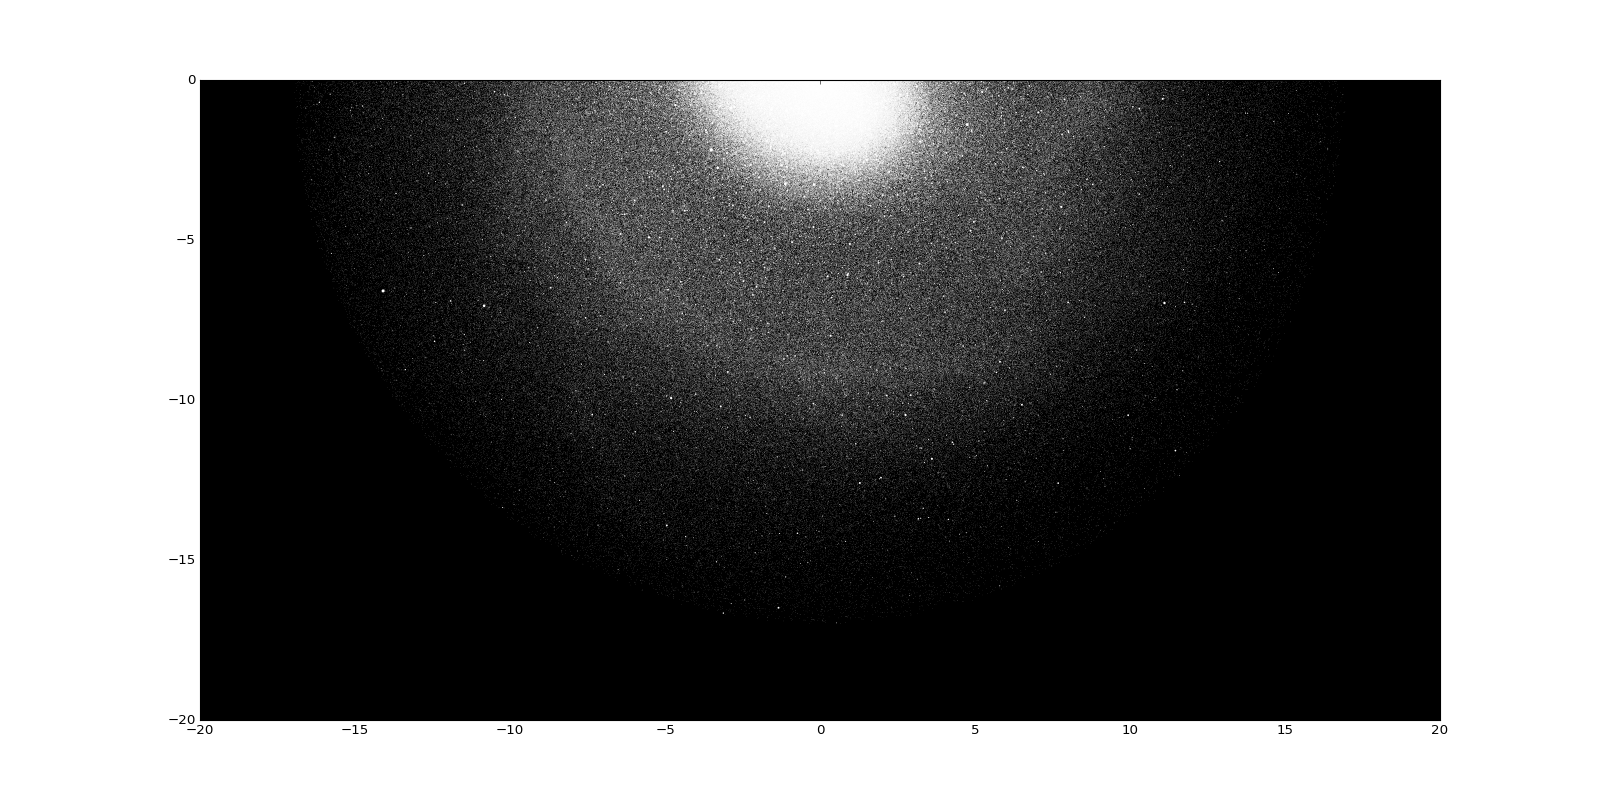

In [37]:
fig, ax1 = plt.subplots(figsize=[20,10])
ax1.patch.set_facecolor("k")
cond = (myhalo.st.r<17)&(myhalo.st.pos3d[:,1]<0)#&(myhalo.st.pos3d[:,0]<0)
ax1.set_xlim([-20,20])
ax1.set_ylim([-20,0])
lu = (lumst_B[cond])
ax1.scatter(myhalo.st.pos3d[cond,0],
                myhalo.st.pos3d[cond,1],s=10*lu/lumst_B.max(),lw=0,c='w')

In [ ]:
fig, ax1 = plt.subplots(figsize=[10,10])
cond = (myhalo.st.r<17)&(myhalo.st.pos3d[:,1]>0)&(myhalo.st.pos3d[:,0]<0)
ax1.set_xlim([-20,0])
ax1.set_ylim([0,20])
lu = (lumst_B[cond])
ax1.scatter(myhalo.st.pos3d[cond,0],
                myhalo.st.pos3d[cond,1],s=8*lu/lumst_B.max(),lw=0,c='w')

In [ ]:
lentho=1e6
band="k"
if band=="k":
        #print MagCalc(myhalo.st.age[0],MagAge,MagU,5.56,myhalo.st.mass[0],myhalo.st.metal[0],MagMet)
        #print MagCalc(myhalo.st.age[1],MagAge,MagU,5.56,myhalo.st.mass[1],myhalo.st.metal[1],MagMet)
        myMagnitude=np.array([ MagCalc(myhalo.st.age[x],MagAge,MagK,.56,myhalo.st.mass[x],myhalo.st.metal[x],MagMet)
                              for x in np.arange(len(myhalo.st.age))]) 
        # MagSol taken from webpage indicated above
        #print 'myMagnitude:',myMagnitude.shape,myMagnitude
        magst_K=myMagnitude[:,0]
        lumst_K=myMagnitude[:,1]


In [ ]:
fig, ax1 = plt.subplots(figsize=[10,10])
cond = (myhalo.st.r<17)&(myhalo.st.pos3d[:,1]>0)&(myhalo.st.pos3d[:,0]<0)
ax1.set_xlim([-20,0])
ax1.set_ylim([0,20])
lu = (lumst[cond])
ax1.scatter(myhalo.st.pos3d[cond,0],
                myhalo.st.pos3d[cond,1],s=8*lu/lumst.max(),lw=0,c='w')

In [ ]:
fig, ax1 = plt.subplots(figsize=[10,10])
cond = (myhalo.st.r<17)&(myhalo.st.pos3d[:,1]>0)&(myhalo.st.pos3d[:,0]<0)
ax1.set_xlim([-20,0])
ax1.set_ylim([0,20])
lu = np.abs(magst[cond])
ax1.scatter(myhalo.st.pos3d[cond,0],
                myhalo.st.pos3d[cond,1],s=8*lu/magst.max(),lw=0,c='w')

In [ ]:
fig, ax = plt.subplots()
ma= np.abs(magst)/np.abs(magst).max()
lu= (lumst/lumst.max())
ax.scatter(lu, ma)

In [ ]:
name = "coco.g2"
unsout=CunsOut(name,"gadget2")
length = len(myhalo.st.pos3d[(myhalo.st.age>-10.)])
pos_out = myhalo.st.pos3d[(myhalo.st.age>-10.)].reshape(length*3).astype(np.float32, copy=False)
mass_out = myhalo.st.mass[(myhalo.st.age>-10.)].astype(np.float32, copy=False)
age_out = myhalo.st.age[(myhalo.st.age>-10.)].astype(np.float32, copy=False)
lum_out = lumst[(myhalo.st.age>-10.)].astype(np.float32, copy=False)
unsout.setArrayF("gas","pos",pos_out)
unsout.setArrayF("gas","mass",mass_out)
unsout.setArrayF("gas","age",age_out)
unsout.setArrayF("gas","rho",lum_out)
unsout.save()

In [ ]:
side = np.linspace(-15,15,512)
mesh = np.meshgrid(side,side)

In [ ]:
pix=12

for i in range(pix-1):
    for j in range(pix-1):
        con = (myhalo.st.pos3d[:,1]>side[i])&(myhalo.st.pos3d[:,1]<side[i+1])
        print sum(lumst_U[con])